# PPO Experiments

This notebook evaluates the PPO (Proximal Policy Optimization) agent on the TestEnv environment.
We analyze convergence, cumulative reward, and policy stability under different hyperparameter settings. <br>

All algorithm code is implemented in `src/models/PPO.py`. <br>
This notebook only shows the direct implementation of an experiment and analysis of the results.

We perform the following experiments:

- PPO with reward shaping and 5 bins <br>


In [1]:
# We import the necessary libraries and modules
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

from stable_baselines3 import PPO
from src.env.TestEnv import HydroElectric_Test
from src.models.PPO import PPOWrapper
from src.utils.visualizations import *
import optuna
import numpy as np
import random


### Hyperparameter optimization

We want to optimize the hyperparameters of the model first. To do this, we set a random seed and perform an optuna study.


In [2]:
# We set a random seed for reproducibility
SEED = 5
np.random.seed(SEED)
random.seed(SEED)


In [3]:
# We set the experiment configurations
REWARD_SHAPING = True

TRAIN_CONFIG = {
    "learning_rate": 3e-4,
    "batch_size": 64,
    "n_steps": 2048,
    "n_epochs": 10,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "total_timesteps": 100000,
}

parameter_dict = {
    'learning_rate': (1e-5, 1e-3),
    'batch_size': [32, 64, 128, 256],
    'n_steps': [512, 1024, 2048, 4096],
}


In [5]:
# We initialize the training environment
train_path = os.path.abspath("data/train.xlsx")
train_env_raw = HydroElectric_Test(train_path)
train_env = PPOWrapper(train_env_raw, reward_shape=REWARD_SHAPING)
train_env.reset(seed=SEED)

# We initialize the validation environment
val_path = os.path.abspath("data/validate.xlsx")
val_env_raw = HydroElectric_Test(val_path)
val_env = PPOWrapper(val_env_raw, reward_shape=REWARD_SHAPING)
val_env.reset(seed=SEED)


(array([0.5       , 0.00440147, 0.        , 0.6666667 , 0.        ],
       dtype=float32),
 {})

In [6]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", parameter_dict["learning_rate"][0], parameter_dict["learning_rate"][1], log=True)
    batch_size = trial.suggest_categorical("batch_size", parameter_dict["batch_size"])
    n_steps = trial.suggest_categorical("n_steps", parameter_dict["n_steps"])

    # Update train config with suggested hyperparameters
    TRAIN_CONFIG["learning_rate"] = learning_rate
    TRAIN_CONFIG["batch_size"] = batch_size
    TRAIN_CONFIG["n_steps"] = n_steps

    # Create and train model
    model = PPO(
        "MlpPolicy",
        train_env,
        verbose=0,
        learning_rate=TRAIN_CONFIG["learning_rate"],
        batch_size=TRAIN_CONFIG["batch_size"],
        n_steps=TRAIN_CONFIG["n_steps"],
        n_epochs=TRAIN_CONFIG["n_epochs"],
        gamma=TRAIN_CONFIG["gamma"],
        gae_lambda=TRAIN_CONFIG["gae_lambda"],
        clip_range=TRAIN_CONFIG["clip_range"],
        seed=SEED,
    )

    # Train the model
    model.learn(total_timesteps=TRAIN_CONFIG["total_timesteps"], log_interval=10)

    # Evaluate on validation environment
    val_env.reset(seed=SEED)
    val_env.reward_shape = False  # Disable reward shaping for evaluation
    
    obs, _ = val_env.reset(seed=SEED)
    done = False
    episode_rewards = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = val_env.step(action)
        done = terminated or truncated
        episode_rewards.append(reward)
    
    total_reward = sum(episode_rewards)
    return total_reward


### Experiment 1: 5 Bins / Reward Shaping


In [7]:
# Run Optuna study for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best hyperparameters: ", study.best_params)


[I 2026-01-28 22:28:54,679] A new study created in memory with name: no-name-8fc0219b-389b-4591-bd6f-74f7626aa160
[I 2026-01-28 22:29:31,309] Trial 0 finished with value: -580.2310451631506 and parameters: {'learning_rate': 1.8046315419872092e-05, 'batch_size': 256, 'n_steps': 2048}. Best is trial 0 with value: -580.2310451631506.
[I 2026-01-28 22:30:48,157] Trial 1 finished with value: -6544.93401066576 and parameters: {'learning_rate': 1.983829573247744e-05, 'batch_size': 32, 'n_steps': 4096}. Best is trial 0 with value: -580.2310451631506.
[I 2026-01-28 22:31:31,836] Trial 2 finished with value: -10593.720138554278 and parameters: {'learning_rate': 4.060236076457722e-05, 'batch_size': 128, 'n_steps': 4096}. Best is trial 0 with value: -580.2310451631506.
[I 2026-01-28 22:32:48,491] Trial 3 finished with value: 216.34211634502586 and parameters: {'learning_rate': 3.558550833253941e-05, 'batch_size': 32, 'n_steps': 4096}. Best is trial 3 with value: 216.34211634502586.
[I 2026-01-28 2

Best hyperparameters:  {'learning_rate': 0.0005052223675720818, 'batch_size': 32, 'n_steps': 1024}


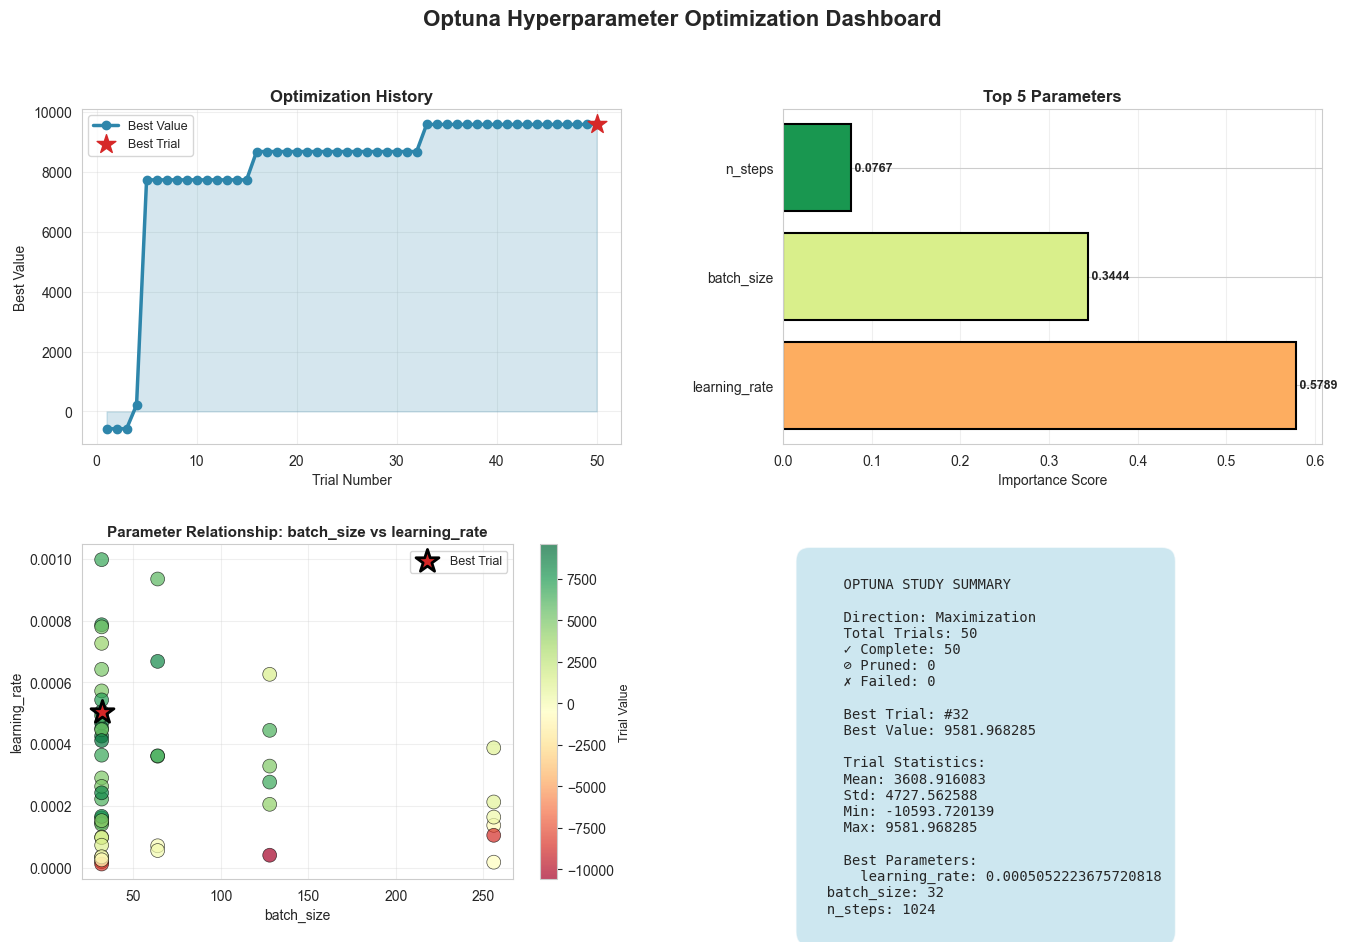

In [8]:
# Visualize the Optuna study results
create_optuna_study_dashboard(study)


In [9]:
# Train with best hyperparameters and evaluate across multiple seeds
TRAIN_CONFIG["learning_rate"] = 0.0005052223675720818
TRAIN_CONFIG["batch_size"] = 32
TRAIN_CONFIG["n_steps"] = 1024

seed_rewards = []

for seed_idx in range(5):
    np.random.seed(seed_idx)
    random.seed(seed_idx)
    
    # Re-initialize environments with new seed
    train_env = PPOWrapper(train_env_raw, reward_shape=REWARD_SHAPING)
    train_env.reset(seed=seed_idx)
    
    val_env = PPOWrapper(val_env_raw, reward_shape=REWARD_SHAPING)
    val_env.reset(seed=seed_idx)
    
    # Create and train model
    model = PPO(
        "MlpPolicy",
        train_env,
        verbose=1,
        learning_rate=TRAIN_CONFIG["learning_rate"],
        batch_size=TRAIN_CONFIG["batch_size"],
        n_steps=TRAIN_CONFIG["n_steps"],
        n_epochs=TRAIN_CONFIG["n_epochs"],
        gamma=TRAIN_CONFIG["gamma"],
        gae_lambda=TRAIN_CONFIG["gae_lambda"],
        clip_range=TRAIN_CONFIG["clip_range"],
        seed=seed_idx,
    )
    
    # Train the model
    model.learn(total_timesteps=TRAIN_CONFIG["total_timesteps"], log_interval=10)
    
    # Evaluate on validation environment
    val_env.reset(seed=seed_idx)
    val_env.reward_shape = False
    
    obs, _ = val_env.reset(seed=seed_idx)
    done = False
    episode_rewards = []
    water_levels = []
    action_history = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = val_env.step(action)
        done = terminated or truncated
        episode_rewards.append(reward)
        water_levels.append(val_env.env.volume)
        action_history.append(action[0])
    
    total_reward = sum(episode_rewards)
    seed_rewards.append(episode_rewards)
    
    print(f"Seed {seed_idx + 1} - Total reward: {total_reward:.2f}")

# Save the best model
model.save("ppo_model_5bins_reward_shaping")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------------
| time/                   |             |
|    fps                  | 1554        |
|    iterations           | 10          |
|    time_elapsed         | 6           |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.006966869 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | -0.000113   |
|    learning_rate        | 0.000505    |
|    loss                 | 2.88e+04    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00724    |
|    std                  | 0.844       |
|    value_loss           | 5.1e+04     |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps              

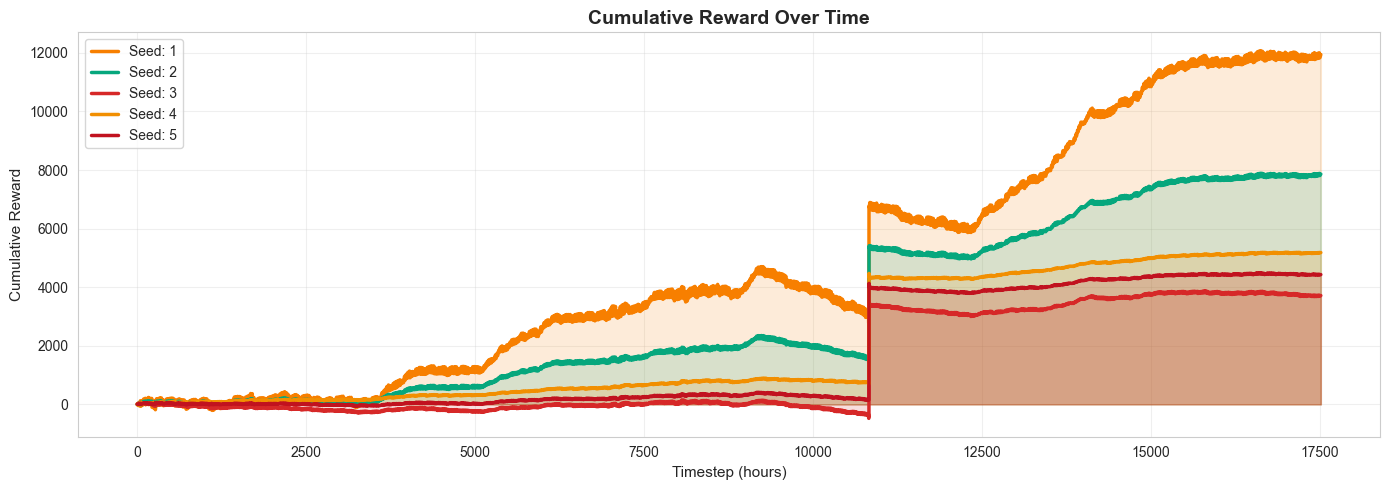

In [10]:
seed_results = {
    "Seed: 1" :seed_rewards[0],
    "Seed: 2" : seed_rewards[1],
    "Seed: 3" : seed_rewards[2],
    "Seed: 4" : seed_rewards[3],
    "Seed: 5" : seed_rewards[4]
}
plot_cumulative_rewards(seed_results)


### Model Performance

We visualize the performance of the model using multiple visualizations.


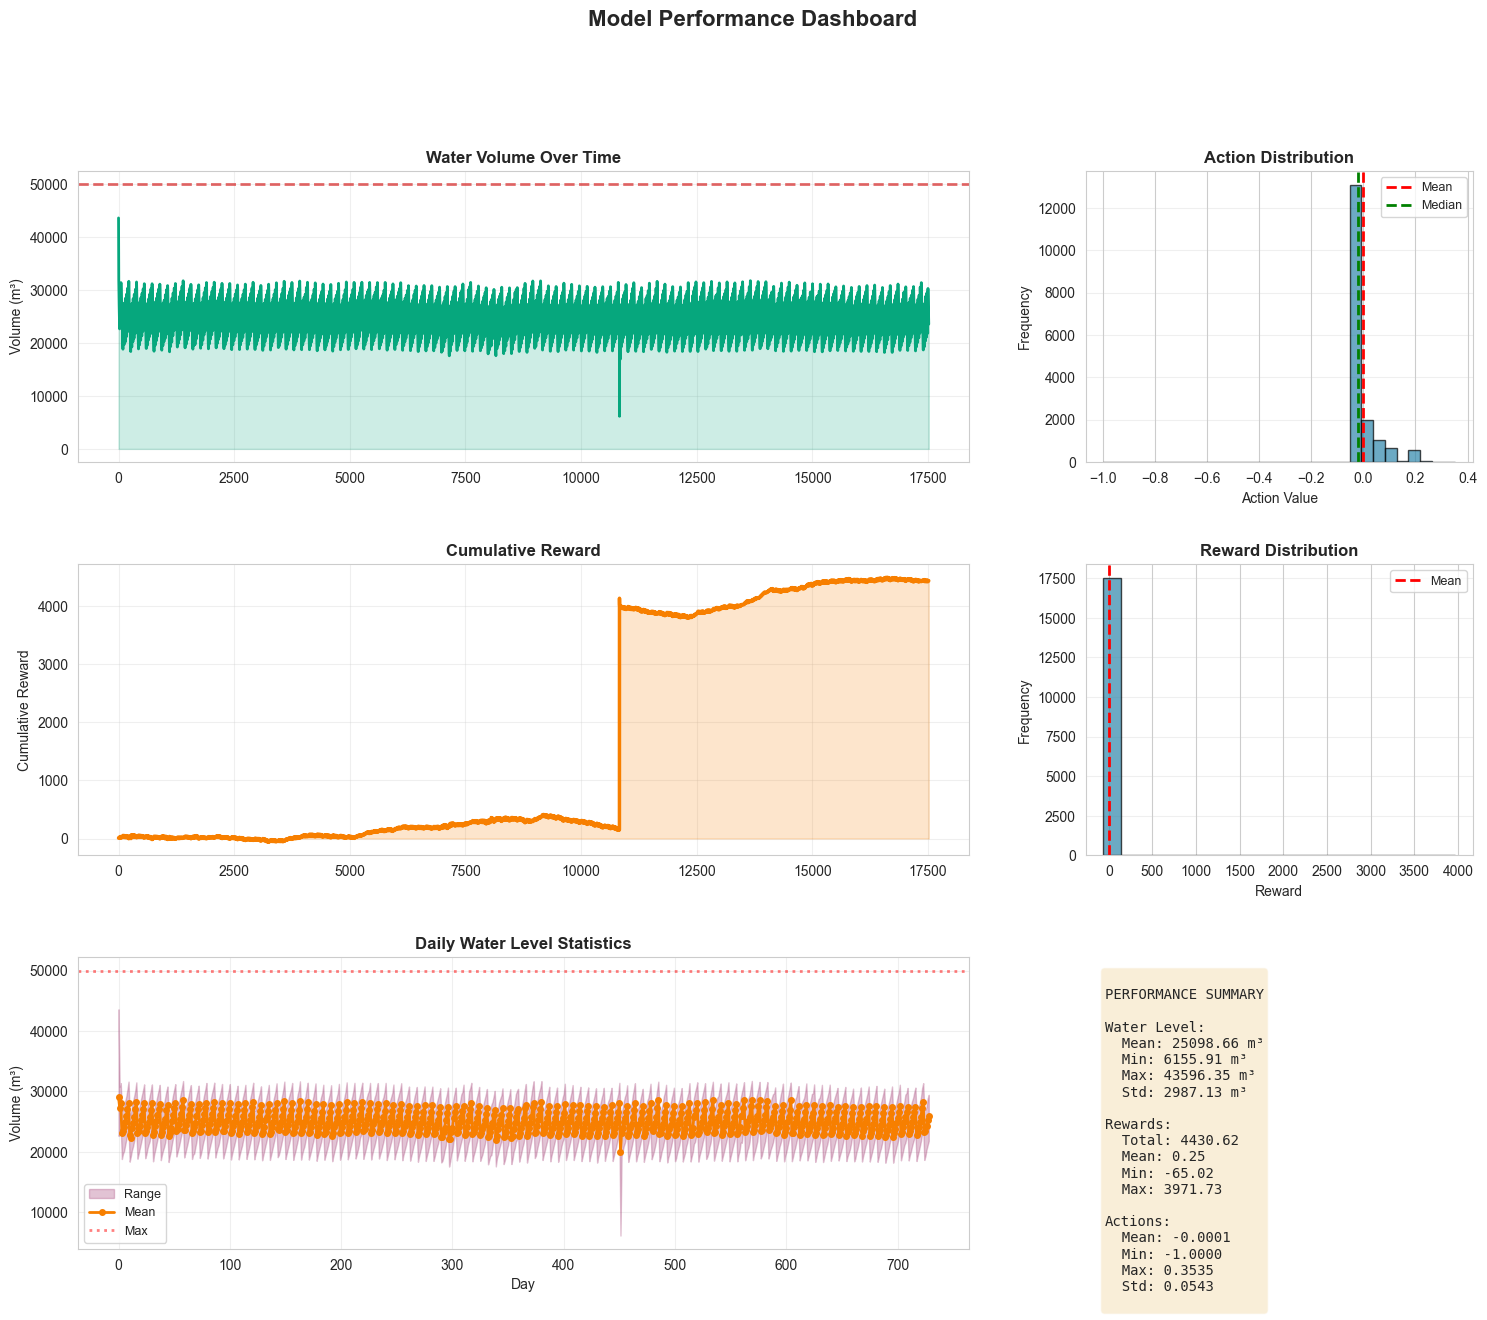

In [14]:
# Create comprehensive performance dashboard using the last trained model
create_performance_dashboard(water_levels, episode_rewards, action_history, max_volume=50000)
